In [1]:
%load_ext autoreload
%autoreload 2
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
HOME = os.environ["HOME"]
map_free_path = os.path.join(HOME, "map_free_localization/mapfree")

if os.path.exists(map_free_path):
    sys.path.append(map_free_path)

In [3]:
from yacs.config import CfgNode as cfg
from torch.utils.data import DataLoader
from typing import Tuple
from lib.find_matches import find_keypoints, find_matches
from lib.unproject_points import unproject_points

from lib.eval.sift_runner import SiftRunner
from lib.eval.mickey_runner import MicKeyRunner

In [4]:

from lib.dataset.mapfree import MapFreeDataset

In [5]:
data_dir = "../lib/tests/test_data"
config_path = os.path.join(data_dir, "testset.yaml")
config = cfg()
config.set_new_allowed(True)
config.DEBUG = False

if os.path.exists(config_path):
    config.merge_from_file(config_path)
    # explicitely setting to None because if loading from yaml it's a string
    config.DATASET.SCENES = None
    config.DATASET.AUGMENTATION_TYPE = None
    config.DATASET.DATA_ROOT = '/media/jprincen/HD/Map Free Localization'
    config.DATASET.DEPTH_ROOT = '/media/jprincen/HD/Map Free Localization/mickey_depths'
else:
    config = None
dataset = MapFreeDataset(config, "val")
dataloader = DataLoader(
    dataset,
    batch_size=1,
)
config_path = os.path.join("../config/sift", "sift_config.yaml")
sift_runner = SiftRunner(config_path)

cl_config_path = "../config/MicKey/curriculum_learning.yaml"
checkpoint_path = "../weights/mickey.ckpt"
# mickey_runner = MicKeyRunner(cl_config_path, checkpoint_path)
 

In [ ]:
estimated_poses = sift_runner.run(dataloader)


  2%|▊                                       | 141/7403 [00:36<32:59,  3.67it/s]

In [34]:
from lib.eval.eval import Eval

eval = Eval.fromMapFree(estimated_poses, dataset)


In [44]:
data_dir = "../lib/tests/test_data"
config_path = os.path.join(data_dir, "testset.yaml")
config = cfg()
config.set_new_allowed(True)
config.DEBUG = False

if os.path.exists(config_path):
    config.merge_from_file(config_path)
    # explicitely setting to None because if loading from yaml it's a string
    config.DATASET.SCENES = None
    config.DATASET.AUGMENTATION_TYPE = None
    config.DATASET.DATA_ROOT = '../lib/tests/test_data/mapfree'
    config.DATASET.DEPTH_ROOT = '/media/jprincen/HD/Map Free Localization/mickey_depths'
else:
    config = None
dataset = MapFreeDataset(config, "val")
dataloader = DataLoader(
    dataset,
    batch_size=1,
)
config_path = os.path.join("../config/sift", "sift_config.yaml")
sift_runner = SiftRunner(config_path)


In [45]:
data = dataset[0]

In [49]:
from lib.camera import Camera
img1 = (
    np.transpose(data["image0"].numpy().squeeze(), (1, 2, 0)) * 255
).astype(np.uint8)
img2 = (
    np.transpose(data["image1"].numpy().squeeze(), (1, 2, 0)) * 255
).astype(np.uint8)
camera1 = Camera.from_K(
    data["K_color0"].numpy().squeeze(), img1.shape[1], img1.shape[0]
)
camera2 = Camera.from_K(
    data["K_color1"].numpy().squeeze(), img2.shape[1], img2.shape[0]
)
result = sift_runner.run_one(
    img1,
    img2,
    data["depth0"].numpy().squeeze(),
    data["depth1"].numpy().squeeze(),
    camera1,
    camera2,
    depth_scale=1.0,
)


((array([[ 0.89666814,  0.08684689,  0.43410121],
       [ 0.0113625 ,  0.97573131, -0.21867624],
       [-0.4425575 ,  0.2010125 ,  0.87392039]]), array([ 0.14138765,  0.04898684, -0.08999581])), 3)


In [41]:
print(result)

((1, 2), 3)


In [43]:
unp = result[0][0], result[0][1], result[1]
print(unp)

(1, 2, 3)


In [35]:
eval.results.keys()

dict_keys(['trans_err', 'rot_err', 'reproj_err', 'confidence'])

(array([1100.,  271.,  124.,   94.,   94.,  104.,  120.,  144.,  140.,
         159.]),
 array([  0.48407803,  18.43511337,  36.3861487 ,  54.33718404,
         72.28821938,  90.23925472, 108.19029005, 126.14132539,
        144.09236073, 162.04339607, 179.9944314 ]),
 <BarContainer object of 10 artists>)

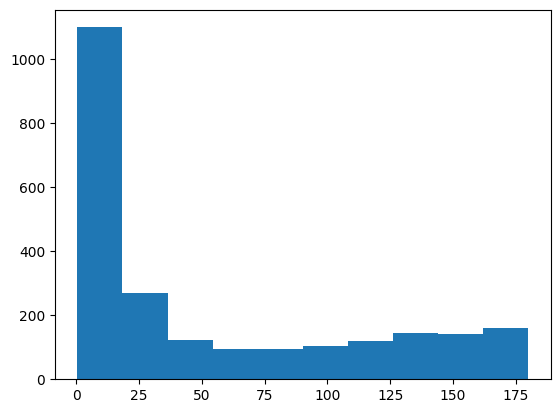

In [39]:
plt.hist(eval.results['rot_err'])
#plt.hist(eval.results['trans_err'])

In [37]:
len(eval.results['trans_err'])

2350

In [38]:
#estimated_poses = mickey_runner.run(dataloader)

100%|█████████████████████████████████████████████| 3/3 [00:10<00:00,  3.63s/it]


In [39]:
eval = Eval.fromMapFree(estimated_poses, dataset)
eval.results

frame number: 0
got passed this
pose frame num: 0
got passed this too
pose frame num: 5
pose frame num: 10
frame number: 5
got passed this
pose frame num: 0
pose frame num: 5
got passed this too
pose frame num: 10
frame number: 10
got passed this
pose frame num: 0
pose frame num: 5
pose frame num: 10
got passed this too


defaultdict(list,
            {'trans_err': [0.25759924238048526,
              0.1749829333885838,
              0.17022848902529342],
             'rot_err': [160.5870103085229,
              155.6276649315167,
              154.63968036447912],
             'reproj_err': [323.4341337248566,
              333.9168422009378,
              339.304942098444],
             'confidence': [949.718994140625,
              978.135009765625,
              996.45361328125]})

In [52]:
pts = np.array([[0.10484917, 0.91921038, 0.24303982],
       [0.20327473, 0.81872091, 0.34857968],
       [0.43809247, 0.88409224, 0.85118211]])
pts2 = np.array([[0.44923764, 0.82595972, 0.1451564 ],
       [0.06629214, 0.24029241, 0.08548403],
       [0.83691768, 0.40759798, 0.21482486]])
pos, num_inliers = find_relative_pose(pts, pts2, 1)
if pos is None:
    print("Yay")

In [51]:
pos


(array([[ 0.41323066,  0.46310121,  0.78407761],
        [-0.49367661,  0.83744857, -0.23444253],
        [-0.76519529, -0.29020194,  0.57468166]]),
 array([-0.43381424, -0.00510537,  0.31607708]))

In [46]:
pts2

array([[0.44923764, 0.82595972, 0.1451564 ],
       [0.06629214, 0.24029241, 0.08548403],
       [0.83691768, 0.40759798, 0.21482486]])

In [130]:
# Given two images find key points and matches
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob

def depth_for_image(image_file):
    return os.path.splitext(os.path.split(image_file)[-1:][0])[0] + ".mickey.png"
    
dataset = "val"
seq = "s00466"
data = os.path.join("/media/jprincen/HD", "Map Free Localization")
depth_data = os.path.join(mickey_path, "data/mickey_depths")
data_set = os.path.join(data, dataset)
seq_images = os.path.join(data_set, seq)
seq_query_images = glob.glob(os.path.join(seq_images, "seq1", "*.jpg"))
seq_query_images.sort()
depth_images = os.path.join(depth_data, dataset, seq, "seq1")
img1_path = seq_query_images[0]
img2_path = seq_query_images[1]
img1 = cv2.imread(img1_path)
fname = depth_for_image(img1_path)
img1_depth = cv2.imread(os.path.join(depth_images, fname), cv2.IMREAD_UNCHANGED)
img2 = cv2.imread(img2_path)
fname = depth_for_image(img2_path)
img2_depth = cv2.imread(os.path.join(depth_images, fname), cv2.IMREAD_UNCHANGED)
print(img1_path, img2_path)

/media/jprincen/HD/Map Free Localization/val/s00466/seq1/frame_00000.jpg /media/jprincen/HD/Map Free Localization/val/s00466/seq1/frame_00001.jpg


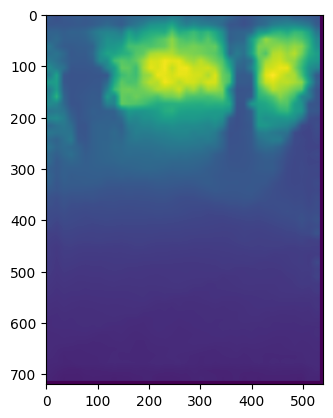

In [119]:
plt.imshow(img1_depth)

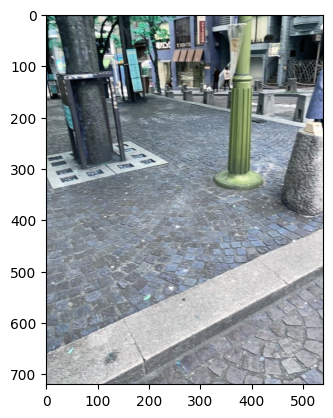

In [120]:
plt.imshow(img1)

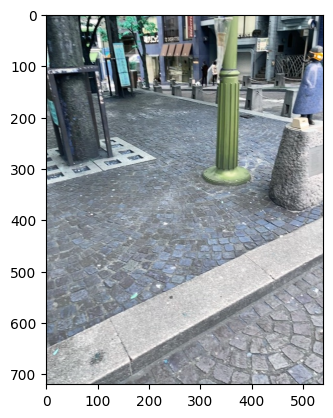

In [121]:
plt.imshow(img2)

In [ ]:
from scipy.spatial.transform import Rotation

kps = find_keypoints([img1, img2])

kp1, des1 = kps[0]
kp2, des2 = kps[1]

pts1, pts2 = find_matches(kp1, des1, kp2, des2)
camera_1 = Camera(590.3821, 590.3821, 269.6031, 351.9277, 540, 720)
camera_2 = Camera(590.1284, 590.1284, 270.3040, 352.0442, 540, 720)
camera_2 = Camera(590.3821, 590.3821, 270.5294, 352.2737, 540, 720)
pts1_3d = unproject_points(pts1, img1_depth, camera_1)
pts2_3d = unproject_points(pts2, img2_depth, camera_2)

(R, t), inliers = find_relative_pose(pts1_3d, pts2_3d, ransac_iterations=2000)

In [125]:
rot = Rotation.from_matrix(R)

In [129]:
rot.as_quat(), t, inliers

(array([ 0.01072962, -0.02204985,  0.00253138,  0.99969609]),
 array([ 0.02262088,  0.0312526 , -0.02691904]),
 1252)

In [127]:
kps = find_keypoints([img1, img1])

kp1, des1 = kps[0]
kp2, des2 = kps[1]

pts1, pts2 = find_matches(kp1, des1, kp2, des2)
camera_1 = Camera(590.3821, 590.3821, 269.6031, 351.9277, 540, 720)
camera_2 = Camera(590.1284, 590.1284, 270.3040, 352.0442, 540, 720)
pts1_3d = unproject_points(pts1, img1_depth, camera_1)
pts2_3d = unproject_points(pts2, img1_depth, camera_1)

In [128]:
find_relative_pose(pts1_3d, pts2_3d, ransac_iterations=100)

((array([[ 1.00000000e+00, -3.24575720e-16, -8.46835878e-17],
         [ 6.07559609e-16,  1.00000000e+00,  5.03729802e-16],
         [ 3.01725246e-16,  3.87071016e-16,  1.00000000e+00]]),
  array([ 4.44089210e-16, -4.66293670e-15,  2.66453526e-15])),
 3956)

In [45]:
MIN_MATCH_COUNT = 10
if len(pts1)>MIN_MATCH_COUNT:
    
    M, mask = cv.findHomography(pts1, pts2, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    
    h,w, _ = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
 
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None


In [46]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
    singlePointColor = None,
    matchesMask = matchesMask, # draw only inliers
    flags = 2)
 
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
 
plt.imshow(img3),plt.show()


NameError: name 'good' is not defined